In [1]:
import numpy as np
import json
import cv2

from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras import backend as K
# from keras.applications.vgg16 import preprocess_input, decode_predictions

from resnet_152 import resnet152_model


Using TensorFlow backend.


In [2]:
model_weights_path = 'models/class_60/model.63-0.93.hdf5'
num_channels = 3
num_classes = 60
img_width, img_height = 224, 224

class_ids = json.load(open("D:\\projects\\car-recognition-ady95\\models\\class_60\\classid_to_folder.json",'r', encoding='utf-8'))
class_ids_ = {v.split()[0]: int(k) for k, v in class_ids.items()}

print(class_ids)
print(class_ids_)

def load_model(img_height, img_width, num_channels, num_classes, model_weights_path):
    model = resnet152_model(img_width, img_height, num_channels, num_classes)
    model.load_weights(model_weights_path, by_name=True)
    return model

{'0': '0001 2010 SONATA', '1': '0002 2010-2012 싼타페', '2': '0003 2010-2013 투싼ix', '3': '0004 2011 AVANTE', '4': '0005 2011 GRANDEUR', '5': '0006 2011 SONATA 하이브리드', '6': '0007 2012 AVANTE 쿠페', '7': '0008 2013 SONATA 더브릴리언트', '8': '0009 2013-2015 싼타페', '9': '0010 2014 AVANTE 더뉴', '10': '0011 2014 SONATA', '11': '0012 2014-2015 투싼ix', '12': '0013 2015 SONATA 터보', '13': '0014 2015 SONATA 하이브리드', '14': '0015 2015-2017 투싼', '15': '0016 2016 AVANTE', '16': '0017 2016 AVANTE 스포츠', '17': '0018 2016 GRANDEUR', '18': '0019 2016-2017 싼타페', '19': '0020 2017 GRANDEUR', '20': '0021 2017 SONATA 뉴라이즈', '21': '0022 2017 SONATA 터보', '22': '0023 2018 AVANTE 더뉴', '23': '0024 2018 AVANTE 더뉴 스포츠', '24': '0025 2018-2019 싼타페', '25': '0026 2018-2019 투싼', '26': '0027 2019 SONATA', '27': '0028 2019 SONATA 터보', '28': '0081 2016 G80', '29': '0082 2017 G70', '30': '0083 2019 G80 SPORT', '31': '0084 2019 G90', '32': '0101 2010 K5', '33': '0102 2010 K7', '34': '0103 2012 K9', '35': '0104 2013 K3', '36': '0105 2013 K7'

In [8]:
# load models
model = load_model(img_height, img_width, num_channels, num_classes, model_weights_path)

In [ ]:
## last conv layer를 비교해서 찾기 위한 녀석
# model.summary()
# from keras.applications import vgg16
# m  = vgg16.VGG16()
# m.summary()

In [ ]:
import os

source_dir = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\train'
dest_dir = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\heatmap\\train'
fail_dir = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\heatmap\\train_fail'
# source_dir = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\valid'
# dest_dir = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\heatmap\\valid'
# fail_dir = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\heatmap\\valid_fail'
last_conv_layer_name = 'res5c_relu' # 최종단
# last_conv_layer_name = 'res4b35_relu' # shape이 줄기 전의 단

def prepare_single_input(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis= 0) # (1, 224, 224, 3)
    # x = preprocess_input(x) # Imagenet의 데이터는 전처리가 조금 다름. (vgg16에 쓰임)
    return x

def generate_heatmap(model, class_idx, last_conv_layer_name):
    output = model.output[:,class_idx]
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0,1,2)) # 이건 바꿔야 할 수 도 있음.
    iterate = K.function([model.input],
                        [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    ch_num = last_conv_layer.output_shape[-1]
    for i in range(ch_num):
        conv_layer_output_value[:,:,i]*=pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)

    del output
    del last_conv_layer
    del grads
    del pooled_grads
    del pooled_grads_value
    del conv_layer_output_value
    return heatmap

def merge_with_heatmap(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(heatmap, 0.5, original_img, 0.5, 0)


# 전체 데이터에 대해서 준비
image_classes = {}
for class_name in os.listdir(source_dir)[0:1]:
    img_folder_name = os.path.join(source_dir,class_name)
    for img_name in os.listdir(img_folder_name):
        img_path = os.path.join(img_folder_name, img_name)
        dest_folder = os.path.join(dest_dir, class_name)
        fail_folder = os.path.join(fail_dir, class_name)
        image_classes[img_path] = (img_path, dest_folder, fail_folder, img_name,class_ids_[class_name.split("-")[0]])

for img_path, (img_path, dest_folder, fail_folder, img_name, correct_class) in image_classes.items():
    print(correct_class,end="/")
    # prepare input image
    x = prepare_single_input(img_path, (224, 224))
    # predict class
    preds = model.predict(x)
    output_class_index = np.unravel_index(preds.argmax(), preds.shape)[1]
    # create_heatmap
    heatmap = generate_heatmap(model, output_class_index, last_conv_layer_name)
    
    try:
        # 원본 이미지와 합성
        original_img = plt.imread(img_path)  # img = cv2.imread(img_path) #issue; allways returns None
        original_img = original_img[..., ::-1] #?
        superimposed_img = merge_with_heatmap(original_img, heatmap)
        # 저장
        if correct_class == output_class_index:
            # 성공이미지 저장
            os.makedirs(dest_folder,exist_ok=True)
            plt.imsave(os.path.join(dest_folder,img_name),superimposed_img)
        else:
            os.makedirs(fail_folder,exist_ok=True)
            # 실패 이미지 저장
            print(output_class_index, correct_class, img_name, fail_folder)
            plt.imsave(os.path.join(fail_folder,f'{correct_class}_{output_class_index}_'+img_name),superimposed_img)
    except Exception as e:
        print(e)
        try:
            print(original_img.shape)
        except Exception as e2:
            print(e2)
        


1/1/1/1/1/1/1/1/OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:687: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'

(327, 429, 3)
1/1/1/OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:687: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'

(327, 427, 3)
1/OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:663: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'

(300, 400, 4)
1/1/1/1/11 1 000031.jpg D:\projects\FaceNet-Real-Time-face-recognition\data_c

0109 2016 K3
0110 2016 K5 MX
0111 2016 K5 SX
0112 2016 K7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


0113 2018 K3
0114 2018 K5 The New
0115 2018 K9
0116 2019 K7 Premier
0131 2004 스포티지2세대
0132 2007 스포티지2세대
0133 2009 쏘렌토
0134 2011 스포티지3세대
0135 2013 쏘렌토
0136 2014 스포티지3세대
0137 2015 스포티지4세대
0138 2015 쏘렌토
0139 2016 쏘렌토
0140 2018 스포티지4세대
0141 2018 쏘렌토
0142 2020 쏘렌토


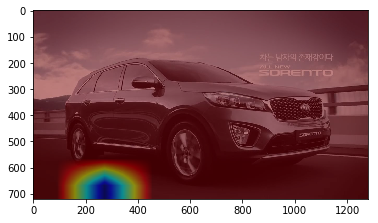

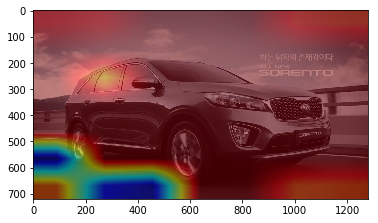

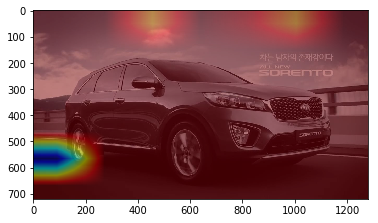

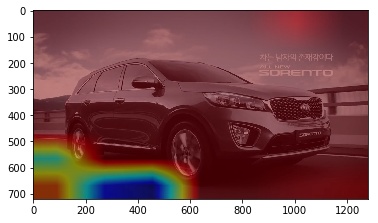

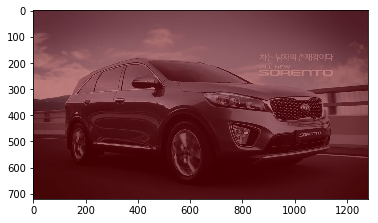

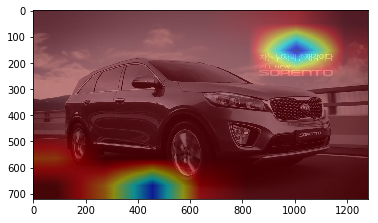

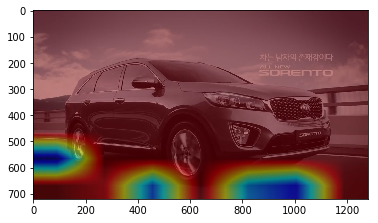

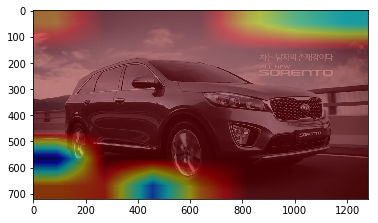

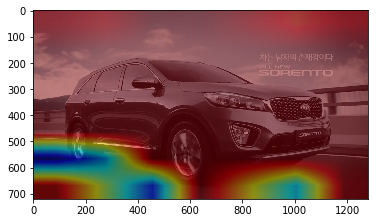

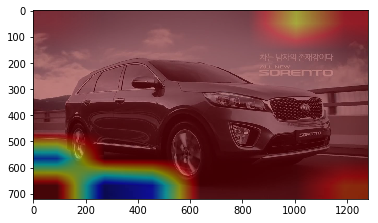

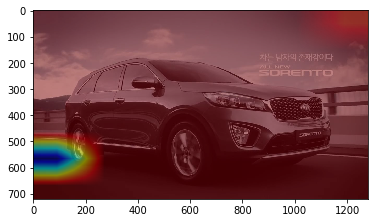

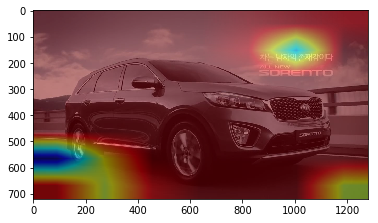

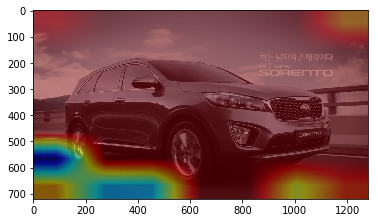

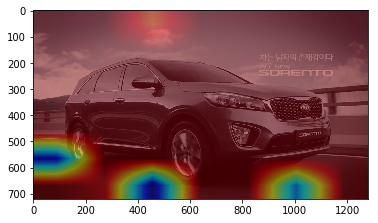

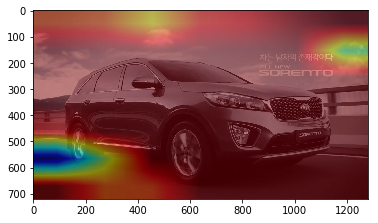

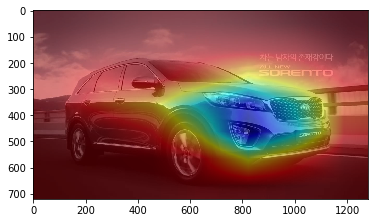

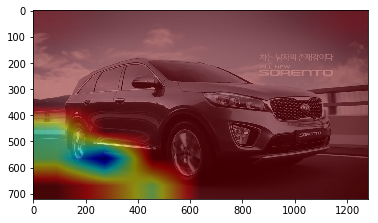

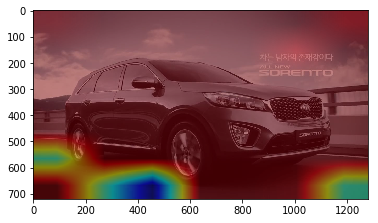

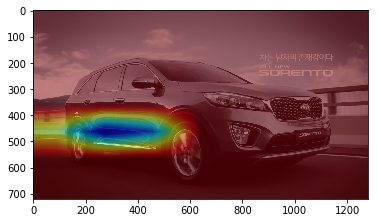

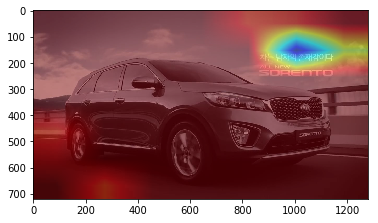

In [10]:
# 단일 이미지에 대한 분석 스크립트
# predict inpits
img_path = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\train\\0006-2011-SONATA-하이브리드\\000031.jpg'
# img_path = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\train\\0138-2015-쏘렌토\\2015_sorento_0006.jpg'
# img_path = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\train\\0138-2015-쏘렌토\\2015_sorento_0007.jpg'
# img_path = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\train\\0001-2010-SONATA\\000006.JPG'
# img_path = 'D:\\projects\\FaceNet-Real-Time-face-recognition\\data_car_brand\\train\\0001-2010-SONATA\\000027.JPG'


# 어느시점에서 영향도를 보기 원하는가?
last_conv_layer_name = 'res5c_relu' # 최종단
# last_conv_layer_name = 'res4b35_relu' # shape이 줄기 전의 단


x = prepare_single_input(img_path, target_size = (224, 224))
preds = model.predict(x)
class_index = np.unravel_index(preds.argmax(), preds.shape)[1]

output = model.output[:,class_index]

last_conv_layer = model.get_layer(last_conv_layer_name)
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2)) # 이건 바꿔야 할 수 도 있음.
iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

ch_num = last_conv_layer.output_shape[-1]

for i in range(ch_num):
    conv_layer_output_value[:,:,i]*=pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)

# 반복되면 메모리 오류가 발생하므로 모델 제외하고 추가적으로 발생되는 네트워크들을 제거함
del output
del last_conv_layer
del grads
del pooled_grads
del pooled_grads_value
del conv_layer_output_value


# 시각화
img = plt.imread(img_path)
# img = cv2.imread(img_path) #issue; allways returns None
img = img[..., ::-1] 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)
plt.figure()
print(class_ids[str(class_index)])
plt.imshow(superimposed_img)


In [45]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [44]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv